In [2]:
import sys
import subprocess
import cdsapi
import os
import xarray as xr
import numpy as np
import pandas as pd
import geopandas as gpd
import cartopy.crs as ccrs
from matplotlib import pyplot as plt

import errno
from dask.diagnostics import ProgressBar
import scipy
import netCDF4
from dask.distributed import progress
import rioxarray

In [3]:
from dask.distributed import Client

#client = Client('tcp://127.0.0.1:42393')
#client = Client(n_workers=56,dashboard_address=':8788', threads_per_worker=2, memory_limit='4GB')
client = Client()
#client

#from dask.distributed import Client

#client = Client(n_workers=56, threads_per_worker=1, memory_limit='4GB')

client

/home/mjolly/miniconda3/lib/python3.9/site-packages/distributed/node.py:151: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 57782 instead
  warnings.warn(


Client Scheduler: tcp://127.0.0.1:60242 Dashboard: http://127.0.0.1:57782/status,Cluster Workers: 8 Cores: 48 Memory: 270.36 GB


In [ ]:
import dask
import dask.distributed  # populate config with distributed defaults
dask.config.config

In [ ]:
#client.loop.add_callback(client.scheduler.retire_workers, close_workers=True)
#client.loop.add_callback(client.scheduler.terminate)
#client.run_on_scheduler(lambda dask_scheduler: dask_scheduler.loop.stop())

In [ ]:
from dask import delayed
import os

def cmd(cmdline):
    print(os.system(cmdline))

x = delayed(cmd)("which python")
res = x.compute()

print(res)

In [ ]:
cmd = 'which python'
t = os.system(cmd)
print(t)

In [ ]:
#client.run_on_scheduler(lambda dask_scheduler=None: 
#    dask_scheduler.close() & sys.exit(0))

In [ ]:
mychunk = {'latitude':25,'longitude':25,'time': -1}
def RunRHExtremes(zone):
    zone = "SAR"
    basedir = '/mnt/DataDrive2/data/mjolly/era5-land'
    #basedir = '/mnt/nas/jolly'
    yrs = range(2020,2021)
    for y in yrs:
        print("Summarizing RH for year:",y)
        ifile = '%s/era5-land-%s-2m_rh-%s-*nc' % (basedir,zone,y)
        print("Outfile: %s:" % (ifile))
        zone_rh = xr.open_mfdataset(ifile,chunks=mychunk,parallel=True,engine='netcdf4')
        outds = zone_rh.resample(time='D').min('time')
        ifile = '%s/era5-land-%s-2m_rhmin-%s.nc' % (basedir,zone,y)
        outds.to_netcdf(ifile,format= 'NETCDF4' )
        outds = zone_rh.resample(time='D').max('time')
        ifile = '%s/era5-land-%s-2m_rhmax-%s.nc' % (basedir,zone,y)
        outds.to_netcdf(ifile,format= 'NETCDF4' )

%time RunRHExtremes("SAR")

In [ ]:
mychunk = {'latitude':25,'longitude':25,'time': -1}
def RunTempExtremes(zone):
    #zone = "SAR"
    basedir = '/mnt/DataDrive2/data/mjolly/era5-land'
    #basedir = '/mnt/nas/jolly'
    yrs = range(2015,2021)
    for y in yrs:
        print("Summarizing Temperatures for year:",y)
        ifile = '%s/era5-land-%s-2m_temperature-%s-*nc' % (basedir,zone,y)
        print("Outfile: %s:" % (ifile))
        zone_temp= xr.open_mfdataset(ifile,chunks=mychunk,parallel=True,engine='netcdf4')
        outds = zone_temp.resample(time='D').min('time')
        ifile = '%s/era5-land-%s-2m_tmin-%s.nc' % (basedir,zone,y)
        outds.to_netcdf(ifile,format= 'NETCDF4' )
        outds = zone_temp.resample(time='D').max('time')
        ifile = '%s/era5-land-%s-2m_tmax-%s.nc' % (basedir,zone,y)
        outds.to_netcdf(ifile,format= 'NETCDF4' )

%time RunTempExtremes("SAR")

In [ ]:
mychunk = {'latitude':25,'longitude':25,'time': -1}
def RunWSMax(zone):
    #zone = "SAR"
    basedir = '/mnt/DataDrive2/data/mjolly/era5-land'
    #basedir = '/mnt/nas/jolly'
    yrs = range(2010,2015)
    for y in yrs:
        print("Summarizing max daily windspeed for year:",y)
        #era5-land-SAR_10m_ws-2017-09.nc
        ifile = '%s/era5-land-%s_10m_ws-%s-*nc' % (basedir,zone,y)
        print("Outfile: %s:" % (ifile))
        zone_temp= xr.open_mfdataset(ifile,chunks=mychunk,parallel=True,engine='netcdf4')
        outds = zone_temp.resample(time='D').max('time')
        ifile = '%s/era5-land-%s-10m_wsmax-%s.nc' % (basedir,zone,y)
        outds.to_netcdf(ifile,format= 'NETCDF4' )

%time RunWSMax("SAR")

Summarizing max daily windspeed for year: 2010
Outfile: /mnt/DataDrive2/data/mjolly/era5-land/era5-land-SAR_10m_ws-2010-*nc:
Summarizing max daily windspeed for year: 2011
Outfile: /mnt/DataDrive2/data/mjolly/era5-land/era5-land-SAR_10m_ws-2011-*nc:
Summarizing max daily windspeed for year: 2012
Outfile: /mnt/DataDrive2/data/mjolly/era5-land/era5-land-SAR_10m_ws-2012-*nc:


In [224]:
# Fix the hourly precip and solar radiation

def special_diff(x):
    d = np.diff(np.append(0,x))
    return np.array(d)


def special_func(data):
    return xr.apply_ufunc(special_diff, data, 
                          input_core_dims=[["time"]],
                          output_core_dims=[["time"]],
                          #exclude_dims=set(("time",)),
            #kwargs={'drop_min': True}, 
                          dask = 'parallelized', 
                          vectorize = True,
                          output_dtypes=[np.float32])

# Fix the time so that the 24 hour accumulations work correctly
#zone_prcp.time.where(zone_prcp.time.dt.hour == 0)
#temp = zone_prcp.time
#tempsave = temp
#temp = xr.where((temp.dt.hour == 0), temp - np.timedelta64(1,'s'), temp)
#zone_prcp['time'] = temp
#print(temp)

In [225]:
x = [0,15,40,80,90,100,130,140,180,190,192,192,200,220,223,224,226,240,250,260,270,280,290,300,310]
print(len(x))
special_func(x)

25


array([ 0, 15, 25, 40, 10, 10, 30, 10, 40, 10,  2,  0,  8, 20,  3,  1,  2,
       14, 10, 10, 10, 10, 10, 10, 10])

In [226]:
len(x)

25

In [250]:
basedir = '/mnt/DataDrive2/data/mjolly/era5-land'

#print("Summarizing max daily windspeed for year:",y)
#era5-land-SAR_10m_ws-2017-09.nc
ifile = '%s/era5-land-SAR-total_precipitation-2020-08.nc' % (basedir)
print("Outfile: %s:" % (ifile))
mychunk = {'latitude':25,'longitude':25,'time':-1}
zone_prcp= xr.open_mfdataset(ifile,chunks=mychunk,parallel=True,engine='netcdf4')
prcp_sl = zone_prcp.isel(latitude=slice(300,304),longitude=slice(300,304))
#zone_prcp.tp[100].plot()
zone_prcp.tp

Outfile: /mnt/DataDrive2/data/mjolly/era5-land/era5-land-SAR-total_precipitation-2020-08.nc:


,Array,Chunk
Bytes,374.81 MB,1.86 MB
Shape,"(744, 364, 346)","(744, 25, 25)"
Count,211 Tasks,210 Chunks
Type,float32,numpy.ndarray


In [251]:
#prcp_sl1.tp[250:270].plo
#temp = zone_prcp.time
#tempsave = temp
#temp = xr.where((temp.dt.hour == 0), temp - np.timedelta64(1,'s'), temp)
#zone_prcp['time'] = temp
#print(temp)

#zone_prcp['time'] = tempsave


In [ ]:
temp = zone_prcp.time
tempsave = tempv.time
temp = xr.where((temp.dt.hour == 0), temp - np.timedelta64(1,'s'), temp)
zone_prcp['time'] = temp
zone_prcp = zone_prcp.tp.resample(time='1D').apply(special_func).compute()

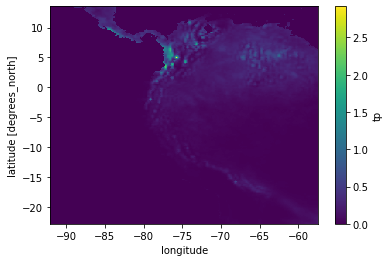

In [256]:
zone_prcp.sum('time').plot()

In [228]:
prcp_sl1 = prcp_sl.isel(latitude=0,longitude=0)

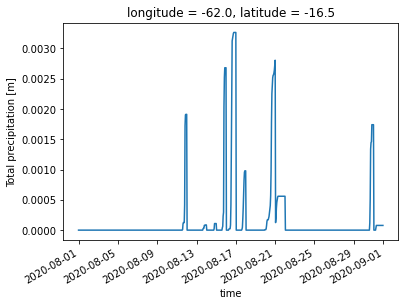

In [229]:
prcp_sl1.tp.plot()

In [234]:
#prcp_sl1.tp[250:270].plot()
tempv = prcp_sl1.tp
#temp = zone_prcp.time
#tempsave = temp
#temp = xr.where((temp.dt.hour == 0), temp - np.timedelta64(1,'s'), temp)
#zone_prcp['time'] = temp
#print(temp)
temp = tempv.time
tempsave = tempv.time
temp = xr.where((temp.dt.hour == 0), temp - np.timedelta64(1,'s'), temp)
tempv['time'] = temp

#new = tempv.resample(time='D').apply(special_func).compute()
#tempv.coords['time']  = tempv.time.dt.ceil('1D')
df = tempv.resample(time='1D').apply(special_func).compute()
tempv['time'] = tempsave
df['time'] = tempsave

In [235]:
df

<xarray.DataArray 'tp' (time: 744)>
array([0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
...
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 1.16467476e-04,
       3.96043062e-04, 8.23110342e-04, 1.08718872e-04, 1.55270100e-05,
       2.79545784e-04, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 3.88324261e-05, 3.88324261e-05,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
      dtype=float32)
Coordinates:
    longitude  float32 -62.0
    latitude   float32 -16.5
  * time       (time) datetime64[ns] 2020-08-01 ... 2020-08-31T23:00:00

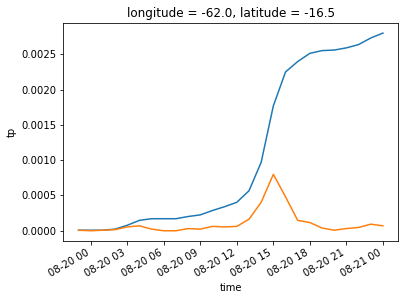

In [247]:
#df[450:500]
tempv[455:481].plot()
df[455:481].plot()

(array([0., 0., 0., 0., 0., 1., 0., 0., 0., 0.]),
 array([-4.99830902e-01, -3.99830878e-01, -2.99830884e-01, -1.99830890e-01,
        -9.98308882e-02,  1.69111532e-04,  1.00169115e-01,  2.00169116e-01,
         3.00169110e-01,  4.00169104e-01,  5.00169098e-01], dtype=float32),
 <BarContainer object of 10 artists>)

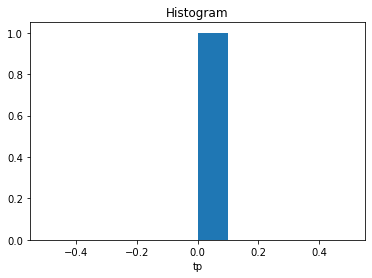

In [206]:
import xarray as xr
data = xr.tutorial.open_dataset('air_temperature')

def special_mean(x, drop_min=False):
    s = np.sum(x)
    n = len(x)
    if drop_min:
        s = s - x.min()
    n -= 1
    return s/n

def special_func(data):
    return xr.apply_ufunc(special_mean, data, input_core_dims=[["time"]], 
            kwargs={'drop_min': True}, dask = 'allowed', vectorize = True)

tempv.resample(time='1YS').apply(special_func)[0].plot()

In [150]:
import numpy as np
import pandas as pd

my_array = np.array([[11,22,33],[44,55,66]])

df = pd.DataFrame(my_array, columns = ['Column_A','Column_B','Column_C'])

print(df)
print(type(df))
print(df.Column_A.dff())



   Column_A  Column_B  Column_C
0        11        22        33
1        44        55        66
<class 'pandas.core.frame.DataFrame'>


AttributeError: 'Series' object has no attribute 'dff'

In [158]:
import numpy as np
import pandas as pd
np_array = np.array([10, 20, 30, 40, 50])
print("NumPy array:")
print(np_array)
new_series = pd.Series(pd.concat(np.array([0]),np_array))
print("Converted Pandas series:")
print(new_series.diff())

NumPy array:
[10 20 30 40 50]


TypeError: cannot concatenate object of type '<class 'numpy.int64'>'; only Series and DataFrame objs are valid

In [115]:
zone_prcp.time
#zone_prcp.time.where(zone_prcp.time.dt.hour == 0)
temp = tempsave = zone_prcp.time
#tempsave = temp
#temp = xr.where((temp.dt.hour == 0), temp - np.timedelta64(1,'s'), temp)
prcp_sl = prcp_sl.chunk({'latitude':1,'longitude':1,'time':-1})
prcp_sl
prcp_sl['time'] = temp
#new_prcp = special_func(prcp_sl.tp)
#new = prcp_sl.tp.resample(time='D').apply(special_func)  * 100
new = prcp_sl.tp.resample(time='D').apply(special_func) 

31.0

In [116]:
new.compute()

ValueError: inconsistent size for core dimension 'dim0': 23 vs 24

In [45]:
tempsave

<xarray.DataArray 'time' (time: 744)>
array(['2020-08-01T00:00:00.000000000', '2020-08-01T01:00:00.000000000',
       '2020-08-01T02:00:00.000000000', ..., '2020-08-31T21:00:00.000000000',
       '2020-08-31T22:00:00.000000000', '2020-08-31T23:00:00.000000000'],
      dtype='datetime64[ns]')
Coordinates:
  * time     (time) datetime64[ns] 2020-08-01 ... 2020-08-31T23:00:00
Attributes:
    long_name:  time

In [41]:
new = new.chunk({'latitude':1,'longitude':1,'time':-1})

In [43]:
new[0].plot(col='time')

ValueError: IndexVariable objects must be 1-dimensional

In [ ]:
prcp_sl.tp.plot()

In [258]:
t_sel = zone_prcp.sel(latitude=-5.178553291448601,longitude=-80.6535891517313,method='nearest').compute()


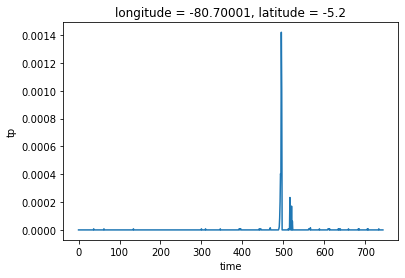

In [259]:
t_sel.plot()

In [257]:
t_sel = new.sel(latitude=-5.178553291448601,longitude=-80.6535891517313,method='nearest').compute()
t_sel2 = prcp_sl.sel(latitude=-5.178553291448601,longitude=-80.6535891517313,method='nearest').compute()

ValueError: inconsistent size for core dimension 'dim0': 23 vs 24

In [ ]:
res = special_mean(t_sel2.tp)


In [ ]:
t_sel = new_prcp.isel(latitude=0,longitude=0)

In [ ]:
res

In [ ]:
t_sel[200:300].plot()
t_sel2.tp.plot()

In [283]:
mychunk = {'latitude':25,'longitude':25,'time': -1}
zone = "SAR"
basedir = '/mnt/DataDrive2/data/mjolly/era5-land'
#basedir = '/mnt/nas/jolly'
y = 2017
ifile = '/mnt/DataDrive2/data/mjolly/era5-land/era5-land-SAR-2m_rhmin-*.nc'

zone_rhmin = xr.open_mfdataset(ifile,chunks=mychunk,parallel=True,engine='netcdf4')

ifile = '/mnt/DataDrive2/data/mjolly/era5-land/era5-land-SAR-2m_tmax-*.nc'

zone_tmax = xr.open_mfdataset(ifile,chunks=mychunk,parallel=True,engine='netcdf4')

ifile = '/mnt/DataDrive2/data/mjolly/era5-land/era5-land-SAR-daily_prcp-*.nc'

zone_prcp = xr.open_mfdataset(ifile,chunks=mychunk,parallel=True,engine='netcdf4')

ifile = '/mnt/DataDrive2/data/mjolly/era5-land/era5-land-SAR-10m_wsmax-*.nc'
zone_ws = xr.open_mfdataset(ifile,chunks=mychunk,parallel=True,engine='netcdf4')

zone_mean_ann_prcp  = zone_prcp.tp.sum('time') * 39.37  # MAP in inches

In [ ]:
t_sel.plot()

In [ ]:
zone_mean_ann_prcp = zone_mean_ann_prcp / 6


In [ ]:
zone_ws.ws[0].plot()

In [ ]:
zone_mean_ann_prcp.plot.hist()

In [ ]:
#ifile = '%s/era5-land-%s-total_precipitation-%s*.nc' % (basedir,zone,y)
#ds = xr.open_mfdataset(ifile,parallel=True,engine='netcdf4')
#zone_tmax_pt = zone_tmax.sel(latitude=-11.58257164274016,longitude=-70.61278378627453,method='nearest')

zone_prcp_pt = zone_prcp.sel(latitude=-11.58257164274016,longitude=-70.61278378627453,method='nearest')

In [ ]:
zone_mean_ann_prcp = zone_mean_ann_prcp / 6


In [ ]:
zone_mean_ann_prcp.plot()

In [ ]:
zone_prcp_pt.tp.plot()
#zone_prcp_pt.tp.resample(time='D').max('time').sum().compute()

In [ ]:
MAP = (zone_prcp.tp.sum('time') / 6) 

In [ ]:
zone_rhmin_pt = zone_rhmin.sel(latitude=-11.58257164274016,longitude=-70.61278378627453,method='nearest')
t = zone_rhmin_pt
zone_tmax_pt = zone_tmax.sel(latitude=-11.58257164274016,longitude=-70.61278378627453,method='nearest')
zone_prcp_pt = zone_prcp.sel(latitude=-11.58257164274016,longitude=-70.61278378627453,method='nearest')

In [ ]:
t.rh.plot()
t.rh.rolling(time=15 ,center=True).mean().plot(color='grey')
plt.grid()
plt.gca().set_ylabel("Relative Humidity")
plt.title("Reserva Territorial Madre de Dios")
plt.gca().set_xlabel("Time")

In [ ]:
zone_tmax_pt.t2m.plot()
#t.rh.rolling(time=15 ,center=True).mean().plot(color='grey')
plt.grid()
plt.gca().set_ylabel("Daily Precipitation (m)")
plt.title("Reserva Territorial Madre de Dios")
plt.gca().set_xlabel("Time")

In [ ]:
mychunk = {'latitude':25,'longitude':25}
zone = "SAR"
basedir = '/mnt/DataDrive2/data/mjolly/era5-land'


ifile = '%s/era5-land-%s-daily_prcp-2015.nc' % (basedir,zone)

zone_prcp = xr.open_mfdataset(ifile,chunks=mychunk,parallel=True,engine='netcdf4')

In [ ]:
zone_prcp

In [ ]:
zone_tmax.t2m[100].plot()

In [ ]:
ofzarr = '/mnt/DataDrive2/data/mjolly/era5-land/era5-land-SAR-2m_tmax.zarr'
zone_tmax.to_zarr(ofzarr)

In [ ]:


#data = zone_srad_pt
#data['time'] = temp
#new = data.ssrd.resample(time='D').apply(special_func) / 3600
#new[0] = 0
##new[1:48].plot()
#zone_full_pt['ssrd'] = new

data = zone_prcp
data['time'] = temp
new = data.tp.resample(time='D').apply(special_func)  * 100
new[0] = 0
new.plot()
zone_full_pt['tp'] = new


In [ ]:
zone_prcp = zone_prcp.chunk({'latitude':25,'longitude':25,'time':-1})
zone_prcp.tp
zone_tmax = zone_tmax.chunk({'latitude':25,'longitude':25,'time':-1})
zone_mean_ann_prcp = zone_mean_ann_prcp.chunk({'latitude':25,'longitude':25})

In [ ]:
zone_mean_ann_prcp
zone_tmax
zone_prcp

In [ ]:
#temp_sl = zone_prcp.isel(latitude=slice(300,304),longitude=slice(300,304))
#newtp = temp_sl.tp.resample(time='D').apply(special_func)  * 100

In [ ]:
temp_sl.tp[100].plot()
temp_sl.time

In [ ]:
tmax_sl = zone_tmax.isel(latitude=slice(300,304),longitude=slice(300,304))
rhmin_sl = zone_rhmin.isel(latitude=slice(300,304),longitude=slice(300,304))
prcp_sl = zone_prcp.isel(latitude=slice(300,304),longitude=slice(300,304))
ws_sl = zone_ws.isel(latitude=slice(300,304),longitude=slice(300,304))
outds = prcp_sl.tp.resample(time='Y').sum('time').mean('time') * 39.37

In [ ]:
outds.plot()

In [ ]:
prcp_sl = prcp_sl.chunk({'latitude':1,'longitude':1,'time':-1})
tmax_sl = tmax_sl.chunk({'latitude':1,'longitude':1,'time': -1})

In [ ]:
prcp_sl.tp

In [284]:
import math
class KBDI:
    yKBDI = 100
    KBDI = 100
    fAvgPrecip = 15
    CummPrecip = 0
    
    def __init__(self,fAvgPrecipIn):
        self.fAvgPrecip = fAvgPrecipIn
        
    def Calc (self,fPrecipAmt, iMaxTemp):
            net = 0
            idq = 0
            pptnet = 0.00
            xkbdi = 0.00
            xtemp = 0.00

            KBDI = int(self.yKBDI)
            if(fPrecipAmt == 0.0):
                self.CummPrecip = 0
            else:
                if(self.CummPrecip > 0.20):
                    pptnet = fPrecipAmt
                    self.CummPrecip = self.CummPrecip + fPrecipAmt
                else:
                    self.CummPrecip = self.CummPrecip + fPrecipAmt
                    if(self.CummPrecip > 0.20):
                        pptnet = self.CummPrecip - 0.20

            net = (100.0 * pptnet) + 0.0005

            net = KBDI - net

            if net > 0:
                KBDI = round(net,0)
            else:
                KBDI = 0
            if(iMaxTemp > 50):
                idq = (800.0 - KBDI) * (0.9679 * math.exp(0.0486 * iMaxTemp) - 8.299) * 0.001 / (1.0 + 10.88 * math.exp(-0.04409 * self.fAvgPrecip)) + 0.5
            self.KBDI = int(KBDI + idq)
            self.yKBDI = self.KBDI
            return self.KBDI


In [285]:
KBDICalc = KBDI(25)

In [286]:
x = []
y = []

for i in range(0,180):
    x.append(i)
    y.append(KBDICalc.Calc(0,75))

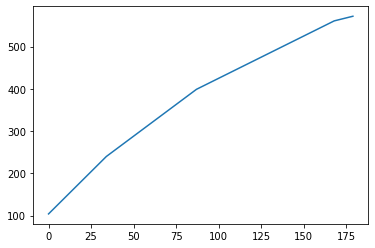

In [287]:
plt.plot(x,y)


In [ ]:
from math import *
#el= [6.5, 7.5, 9.0, 12.8, 13.9, 13.9, 12.4, 10.9, 9.4, 8.0, 7.0, 6.0 ]
#fl = [-1.6, -1.6, -1.6, 0.9, 3.8, 5.8, 6.4, 5.0, 2.4, 0.4, -1.6, -1.6 ]

# Correction for southern hemisphere
#https://cfs.nrcan.gc.ca/pubwarehouse/pdfs/29152.pdf


class CFFDRS:
    old_ffmc = 85
    old_dmc = 6
    old_dc = 15
    ffmc = 0
    dmc = 0
    dc = 0
    isi = 0
    bui = 0
    fwi = 0
    dsr = 0
    el = [10.1,9.6,9.1,8.5,8.1,7.8,7.9,8.3,8.9,9.4,9.9,10.2]
    fl = [6.4,5.0,2.4,0.4,-1.6,-1.6,-1.6,-1.6,-1.6,0.9,3.8,5.8]
    def __init__(self, startffmc,startdmc,startdc):
        self.old_ffmc = startffmc
        self.old_dmc = startdmc
        self.old_dc = startdc

    def Calc(self,dayOfYear, month, year, _temp, rh, _ws,_rain):
        SI= True
        temp = (_temp - 32) * 5 / 9  # Convert temp to C
        ws = _ws * 1.609 # Convert MPH to KPH
        rain = _rain * 25.40  # Convert inches to mm
        
        if(SI):
            temp = _temp
            ws = _ws
            rain = _rain
        #start with ffmc
        wmo = 147.2 * (101 - self.old_ffmc) / (59.5 + self.old_ffmc)
        if(rain > 0.5):
            ra = rain - 0.5
            if(ra < 0.1):
                ra = 0.1
            if(wmo > 150.0):
                wmo = wmo + 42.5 * ra * exp(-100.0 / (251 - wmo)) * (1.0 - exp(-6.93 / ra)) + 0.0015 * (wmo - 150) * (wmo - 150) * sqrt(ra)
            else:
                wmo = wmo + 42.5 * ra * exp(-100.0 / (251 - wmo)) * (1.0 - exp(-6.93 / ra))

        if(wmo > 250):
            wmo = 250
        ed = 0.942 * pow(rh, 0.679) + 11.0 * exp((rh - 100.0) / 10.0)+ 0.18 * (21.1 - temp) * (1.0 - exp(rh * -0.115))

        ew = 0.618 * pow(rh, 0.753) + 10.0 * exp((rh - 100.0) / 10.0) + 0.18 * (21.1 - temp) * (1.0 - exp(rh * -0.115))
        print(ed,ew,wmo)
        if(wmo < ed and wmo < ew):
            z = 0.424 * (1.0 - pow(((100.0 - rh) / 100.0), 1.7)) + 0.0694 * sqrt(ws) * (1.0 - pow((100.0 - rh) / 100.0, 8.0))
            x = z * 0.581 * exp(0.0365 * temp)
            wm = ew - (ew - wmo) * pow(10.0, -x)
        elif(wmo > ed):
            z = 0.424 * (1.0 - pow(rh / 100.0, 1.7)) + 0.0694 * sqrt(ws) * (1.0 - pow(rh / 100.0, 8.0))
            x = z * 0.581 * exp(0.0365 * temp)
            wm = ed + (wmo - ed) * pow(10.0, -x)
        else:
            wm = wmo
        if(wm < 0.0):
            wm = 0.0
        ffmc = 59.5 * (250.0 - wm) / (147.2 + wm)
        if(ffmc > 101.0):
            ffmc = 101.0
        if(ffmc < 0):
            ffmc = 0
        #now the DMC part
        t = temp
        if(temp < -1.1):
            t = -1.1
        rk = 1.894 * (t + 1.1) * (100.0 - rh) * self.el[month - 1] * 0.0001
        if(rain <= 1.5):
            pr = self.old_dmc
        else:
            ra = rain
            rw = 0.92 * ra - 1.27
            wmi = 20.0 + 280.0 / exp(0.023 * self.old_dmc)
            if(self.old_dmc <= 33):
                b = 100.0 / (0.5 + 0.3 * self.old_dmc)
            elif(self.old_dmc <= 65):
                b = 14.0 - 1.3 * log(self.old_dmc)
            else:
                b = 6.2 * log(self.old_dmc) - 17.2
            wmr = wmi + 1000.0 * rw / (48.77 + b * rw)
            pr = 43.43 * (5.6348 - log(wmr - 20.0))

        if(pr < 0.0):
            pr = 0.0
        dmc = pr + rk
        if(dmc < 0.0):
            dmc = 0.0
        #calculate DC
        if(temp < -2.8):
            t = -2.8

        if(rain <= 2.801):
            dr = self.old_dc
        else:
            ra = rain
            rw = 0.83 * ra - 1.27
            smi = 800 * exp(-self.old_dc / 400.0)
            qr = smi + 3.937 * rw
            dr = 400 * log(800 / qr)
            if(dr < 0):
                dr = 0

        v = 0.36 * (t + 2.8) + self.fl[month - 1]
        if(v < 0):
            v = 0
        dc = dr + v * 0.5
        if (dc < 0.0):
            dc = 0.0
        #calc isi and the rest...
        sf = 91.9 * exp(-0.1386 * wm) * (1.0 + pow(wm, 5.31) / 4.93e07)
        isi = 0.208 * sf * exp(0.05039 * ws)

        if(dmc == 0.0 and dc == 0.0):
            bui = 0.0
        elif(dmc <= 0.4 * dc):
            bui = 0.8 * dmc * dc / (dmc + 0.4 * dc)
        else:
            bui = dmc - (1 - 0.8 * dc / (dmc + 0.4 * dc)) * (0.92 + pow(0.0114 * dmc, 1.7))
        if(bui < 0.0):
            bui = 0.0
        if(bui <= 80):
            fd = 0.626 * pow(bui, 0.809) + 2
        else:
            fd = 1000 / (25 + 108.64 * exp(-0.023 * bui))
        B = 0.1 * isi * fd
        if(B > 1):
            fwi = exp(2.72 * pow(0.434 * log(B), 0.647))
        else:
            fwi = B
        dsr = 0.0272 * pow(fwi, 1.77)
        self.old_ffmc = ffmc
        self.old_dc = dc
        self.old_dmc = dmc
        return fwi
    

In [ ]:
CFFDRSCalc = CFFDRS(85,6,15)

In [ ]:
CFFDRSCalc.Calc(180,6,2020,25,20,10,0)



In [288]:
def calc_kbdi_gufunc(tmax,prcp,annp=25):
    print(annp)
    #print(tmax.shape)
    #print(prcp.shape)
    #print(annp.shape)
    i = 0
    tmax = np.array(tmax)
    prcp = np.array(prcp)
    tmaxf = (tmax - 273.15) * 9/5 + 32 # Convert K to F
    prcpin = prcp * 39.37 # Convert meters to inches
    KBDICalc = KBDI(annp)
    kbdi = []
    for t in tmax:
        kbdi.append(KBDICalc.Calc(prcpin[i],tmaxf[i]))
        i = i + 1
    return np.array(kbdi)

def calc_kbdi(x, y,annp):
    return xr.apply_ufunc(
        #calc_rh_gufunc,
        calc_kbdi_gufunc,
        x,
        y,
        annp,
        dask="parallelized",
        input_core_dims=[["time"],["time"],[]], 
        output_core_dims=[["time"]],
        #kwargs={'annp': annp},
        vectorize=True, # !Importat!
        output_dtypes=[x.dtype]
    )

In [289]:
tmax = [280,285,290,295,300]
prcp = [0,0,0.01,0,0]
calc_kbdi_gufunc(tmax,prcp,80)

80


array([100, 102,  89, 101, 122])

In [ ]:
#zone_mean_ann_prcp
#zone_tmax
zone_prcp

In [290]:
zone_tmax = zone_tmax.chunk({'latitude':25,'longitude':25,'time':-1})
zone_prcp = zone_prcp.chunk({'latitude': 25, 'longitude':25,'time':-1})
zone_mean_ann_prcp.chunk({'latitude':25,'longitude':25})

<xarray.DataArray 'tp' (latitude: 364, longitude: 346)>
dask.array<mul, shape=(364, 346), dtype=float32, chunksize=(25, 25), chunktype=numpy.ndarray>
Coordinates:
  * longitude  (longitude) float32 -92.0 -91.9 -91.8 -91.7 ... -57.7 -57.6 -57.5
  * latitude   (latitude) float32 13.5 13.4 13.3 13.2 ... -22.6 -22.7 -22.8

In [ ]:
zone_tmax.t2m

In [291]:
#zone_mean_ann_prcp
#zone_tmax
#zone_prcp
t = calc_kbdi(zone_tmax.t2m,zone_prcp.tp,zone_mean_ann_prcp)


In [292]:
zone_kbdi = zone_tmax
zone_kbdi = zone_kbdi.drop('t2m')
zone_kbdi['kbdi'] = t

In [293]:
zone_kbdi = zone_kbdi.transpose("time", "latitude", "longitude").compute()
ofile = '/mnt/DataDrive2/data/mjolly/era5-land/era5-land-SAR-kbdi-2015-2020.zarr'
#outfwi = zone_tmax
#outfwi = outfwi.drop('t2m')
#outfwi['kbdi'] = kbdi
zone_kbdi.to_zarr(ofile,mode='w')

In [299]:
#zone_kbdi = zone_kbdi.drop('t2m')
zone_kbdi

<xarray.Dataset>
Dimensions:    (latitude: 364, longitude: 346, time: 2192)
Coordinates:
  * time       (time) datetime64[ns] 2015-01-01 2015-01-02 ... 2020-12-31
  * longitude  (longitude) float32 -92.0 -91.9 -91.8 -91.7 ... -57.7 -57.6 -57.5
  * latitude   (latitude) float32 13.5 13.4 13.3 13.2 ... -22.6 -22.7 -22.8
Data variables:
    kbdi       (time, latitude, longitude) float32 100.0 100.0 ... 681.0 671.0

In [300]:
# Write the outputs by year to a GeoTIFF file using RIOXarray
ofile = '/mnt/DataDrive2/data/mjolly/era5-land/era5-land-SAR-kbdi-2015-2020.zarr'
outkbdi = xr.open_mfdataset(ofile,parallel=True,engine='zarr')
outkbdi = outkbdi.fillna(-999.9)
for y in range(2015,2021):
    st = "%s-01-01" % (y)
    en = "%s-12-31" % (y)
    tempdf = outkbdi.loc[dict(time=slice(st, en))]
    ofile = '/mnt/DataDrive2/data/mjolly/era5-land/era5-land-SAR-kbdi-%s.tiff' % (y)
    tempdf.kbdi.rio.to_raster(ofile)

In [ ]:
zone_kbdi.kbdi[3].plot()

In [ ]:
kbdi_unweighted_seasonal = zone_kbdi.kbdi.groupby('time.season').median('time').compute()

In [ ]:
t_sel = zone_kbdi.sel(latitude=-5.178553291448601,longitude=-80.6535891517313,method='nearest')


In [ ]:
t_sel.kbdi.groupby('time.dayofyear').median('time').plot(label="Piura")

t2_sel.kbdi.groupby('time.dayofyear').median('time').plot(label="Madre de Dios")
plt.legend()
plt.grid()
plt.title("Mean daily KBDI (2015-2020)")

In [ ]:
t2_sel = zone_kbdi.sel(latitude=-11.58257164274016,longitude=-70.61278378627453,method='nearest')

In [ ]:
kbdi_unweighted_seasonal

In [ ]:
notnull = pd.notnull(kbdi_unweighted_seasonal[0])
ds_unweighted = kbdi_unweighted_seasonal

In [ ]:
# Load the country boundaries file
countries_path = r"./data"
countries_path = os.path.join(countries_path, "ne_10m_admin_0_countries_lakes.shp")
states_path = r"./data"
states_path = os.path.join(states_path, "ne_10m_admin_1_states_provinces_lakes.shp")

# Load the state boundaries file and filter for CONUS
states_gdf = gpd.read_file(states_path)
#states_gdf = states_gdf[states_gdf.iso_a2 == "PE" or states_gdf.iso_a2 == "CO"]
#states_gdf = states_gdf[states_gdf.name != "Alaska" ]
#states_gdf = states_gdf[states_gdf.name != "Hawaii"]
states_gdf.head()

#states_gdf = states_gdf[states]
countries_gdf = gpd.read_file(countries_path)
#countries_gdf.head()
SARBnd = states_gdf[states_gdf['iso_a2'].isin(['PE','CO','EC','BO'])]

In [ ]:
# Quick plot to show the results

SARCountries = SARBnd.dissolve(by='iso_a2')


fig, axes = plt.subplots(nrows=4, ncols=1, figsize=(5,12))
for i, season in enumerate(('DJF', 'MAM', 'JJA', 'SON')):

    ds_unweighted.sel(season=season).where(notnull).plot.pcolormesh(
        ax=axes[i], vmin=0, vmax=800, cmap='Spectral_r',
        add_colorbar=True, extend='both')

    SARCountries.plot(color='None',edgecolor='grey',linewidth=0.5,ax=axes[i],zorder=4)
    SARBnd.plot(color='None',edgecolor='red',linewidth=0.2,linestyle=':',ax=axes[i])
    #ax.set(title="Raster Layer with Vector Overlay")
    #ax.axis('off')
    #axes[i].grid()

    axes[i].set_ylabel(season)
    

for ax in axes.flat:
    ax.axes.get_xaxis().set_ticklabels([])
    ax.axes.get_yaxis().set_ticklabels([])
    ax.axes.axis('tight')
    ax.set_xlabel('')

axes[0].set_title('Mean Seasonal Keetch Byram Drought Index')


plt.tight_layout()

fig.suptitle('Keetch Byram Drought Index (2015-2020)', fontsize=16, y=1.02)

#Text(0.5, 1.02, 'Seasonal Surface Air Temperature')



In [ ]:
t_sel.plot()
plt.gca().set_ylabel("Keetch Byram Drought Index (KBDI)")

In [ ]:
outds = outds.chunk({'latitude':1,'longitude':1})
outds

In [ ]:
t.compute()

In [ ]:
s = t.isel(latitude=0,longitude=0)

In [ ]:
s.plot()

In [ ]:
prcp_sl = prcp_sl.chunk({'latitude':1,'longitude':1,'time':-1})
tmax_sl = tmax_sl.chunk({'latitude':1,'longitude':1,'time': -1})

In [ ]:
tmax_sl.t2m

In [ ]:
tmax_sl = tmax_sl.chunk({'latitude':1,'longitude':1,'time':-1})
rhmin_sl = rhmin_sl.chunk({'latitude':1,'longitude':1,'time':-1})
prcp_sl = prcp_sl.chunk({'latitude':1,'longitude':1,'time':-1})
ws_sl = ws_sl.chunk({'latitude':1,'longitude':1,'time':-1})


In [ ]:
def calc_fwi_gufunc(t,r,p,w,jd,m,y,lat):
    i = 0
    temp = np.array(t) - 273.15 # Convert K to C
    rh = np.array(r) 
    prcp = np.array(p) * 1000 # Convert meters to inches
    #tmaxf = (tmax - 273.15)  
    #prcpin = prcp 
    ws = np.array(w) * 3.6 # Convert m/s to kph
    jd = np.array(jd)
    m = np.array(m)
    y = np.array(y)
    #jd = tm.dt.dayofyear.values
    #y = tm.dt.year.values
    #m = tm.dt.month.values

    
    CFFDRSCalc = CFFDRS(85,6,15)  # Make an instance of the FWI class
    
    fwi = []
    for t in temp:
        fwi.append(CFFDRSCalc.Calc(jd[i],m[i],y[i],t,rh[i],ws[i],prcp[i]))
        i = i + 1
    return np.array(fwi)

def calc_fwi(t,r,p,w,jd,m,y,lat):
    return xr.apply_ufunc(
        #calc_rh_gufunc,
        calc_fwi_gufunc,
        t,
        r,
        p,
        w,
        jd,
        m,
        y,
        lat,
        dask="parallelized",
        input_core_dims=[["time"],["time"],["time"],["time"],["time"],["time"],["time"],[]], 
        output_core_dims=[["time"]],
        #kwargs={'annp': annp},
        vectorize=True, # !Importat!
        output_dtypes=[t.dtype]
    )

In [ ]:
fwi = calc_fwi(tmax_sl.t2m,rhmin_sl.rh,prcp_sl.tp,ws_sl.ws,tmax_sl.jday,tmax_sl.month,tmax_sl.year,tmax_sl.latitude)

In [ ]:
#fwi[0].plot()

fwi = fwi.transpose("time", "latitude", "longitude").compute()

In [1]:
fwi[0].plot()


NameError: name 'fwi' is not defined

In [ ]:
t_sel = fwi.isel(latitude=0,longitude=0).plot()

In [ ]:
tmax_sl['jday'] = tmax_sl.time.dt.dayofyear
tmax_sl['month'] = tmax_sl.time.dt.month
tmax_sl['year'] = tmax_sl.time.dt.year

In [ ]:
tmax_sl

In [ ]:
zone_tmax['jday'] = zone_tmax.time.dt.dayofyear
zone_tmax['month'] = zone_tmax.time.dt.month
zone_tmax['year'] = zone_tmax.time.dt.year
zone_tmax = zone_tmax.chunk({'latitude':25,'longitude':25,'time':-1})
zone_rhmin = zone_rhmin.chunk({'latitude':25,'longitude':25,'time':-1})
zone_prcp = zone_prcp.chunk({'latitude':25,'longitude':25,'time':-1})
zone_ws = zone_ws.chunk({'latitude':25,'longitude':25,'time':-1})

In [ ]:
fwi = calc_fwi(zone_tmax.t2m,zone_rhmin.rh,zone_prcp.tp,zone_ws.ws,zone_tmax.jday,zone_tmax.month,zone_tmax.year,zone_tmax.latitude)

In [ ]:
ofile = '/mnt/DataDrive2/data/mjolly/era5-land/era5-land-SAR-2m_fwi-2015-2020.zarr'
fwi = fwi.transpose("time", "latitude", "longitude")
outfwi = zone_tmax
outfwi = outfwi.drop('t2m')
outfwi['fwi'] = fwi
outfwi.to_zarr(ofile,mode='w')

In [4]:
ofile = '/mnt/DataDrive2/data/mjolly/era5-land/era5-land-SAR-2m_fwi-2015-2020.zarr'
fwi = xr.open_dataset(ofile,engine='zarr')

In [5]:
fwi

<xarray.Dataset>
Dimensions:    (latitude: 364, longitude: 346, time: 2192)
Coordinates:
  * latitude   (latitude) float32 13.5 13.4 13.3 13.2 ... -22.6 -22.7 -22.8
  * longitude  (longitude) float32 -92.0 -91.9 -91.8 -91.7 ... -57.7 -57.6 -57.5
  * time       (time) datetime64[ns] 2015-01-01 2015-01-02 ... 2020-12-31
Data variables:
    fwi        (time, latitude, longitude) float32 ...
    jday       (time) int64 ...
    month      (time) int64 ...
    year       (time) int64 ...

In [48]:
t_sel = fwi.sel(latitude=-13.628599364233533,longitude=-71.38606218810298,method='nearest')
t_sel2 = t_sel.sel(time=slice('2020-01-01', '2020-12-31'))

<xarray.DataArray 'fwi' (quantile: 1)>
array([11.58932331])
Coordinates:
  * quantile  (quantile) float64 0.99


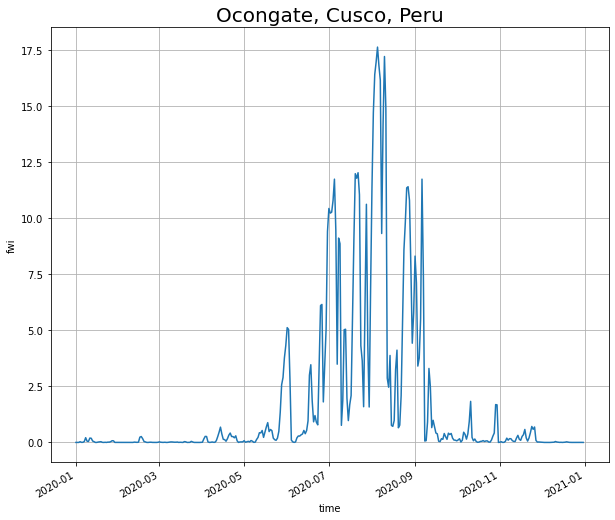

In [64]:
plt.figure(figsize=(10, 8))
#plt.suptitle("Ocongate, Cusco, Peru")
t_sel2.fwi.plot(ax=plt.gca())
plt.gca().set_title("Ocongate, Cusco, Peru",fontsize=20)
print(t_sel.fwi.quantile([0.99]))
plt.grid()

In [28]:
t_sel2 = t_sel.loc[dict(time=slice("2020-01-01", "2000-12-31"))]
#a.loc[dict(time=slice("2000-01-01", "2000-01-02"))]

In [31]:
t_sel.time

<xarray.DataArray 'time' (time: 2192)>
array(['2015-01-01T00:00:00.000000000', '2015-01-02T00:00:00.000000000',
       '2015-01-03T00:00:00.000000000', ..., '2020-12-29T00:00:00.000000000',
       '2020-12-30T00:00:00.000000000', '2020-12-31T00:00:00.000000000'],
      dtype='datetime64[ns]')
Coordinates:
    latitude   float32 -13.6
    longitude  float32 -71.4
  * time       (time) datetime64[ns] 2015-01-01 2015-01-02 ... 2020-12-31

In [ ]:
# Write the outputs by year to a GeoTIFF file using RIOXarray
ofile = '/mnt/DataDrive2/data/mjolly/era5-land/era5-land-SAR-2m_fwi-2015-2020.zarr'
outfwi = xr.open_mfdataset(ofile,parallel=True,engine='zarr')
outfwi = outfwi.fillna(-999.9)
for y in range(2015,2021):
    st = "%s-01-01" % (y)
    en = "%s-12-31" % (y)
    tempdf = outfwi.loc[dict(time=slice(st, en))]
    ofile = '/mnt/DataDrive2/data/mjolly/era5-land/era5-land-SAR-fwi-%s.tiff' % (y)
    tempdf.fwi.rio.to_raster(ofile)

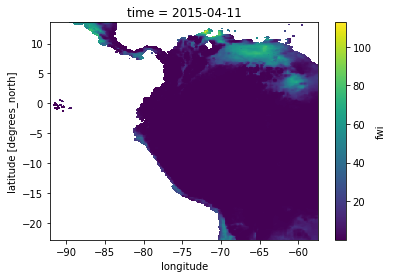

In [272]:
outfwi.fwi[100].plot()

In [ ]:
fwi_seasonal = outfwi.fwi.groupby('time.month').median('time').compute()

In [ ]:
fwi_seasonal = outfwi.fwi.median('time').compute()


In [ ]:
fwi_seasonal.plot(levels=16)

In [ ]:
# Quick plot to show the results

SARCountries = SARBnd.dissolve(by='iso_a2')
ds_unweighted = fwi_seasonal
notnull = pd.notnull(ds_unweighted[0])
fig, axes = plt.subplots(nrows=4, ncols=3, figsize=(5,12))
for i in range(1,5):
    ds_unweighted.sel(month=i).plot()
    #SARCountries.plot(color='None',edgecolor='grey',linewidth=0.5,ax=axes[i],zorder=4)
    #SARBnd.plot(color='None',edgecolor='red',linewidth=0.2,linestyle=':',ax=axes[i])
    #axes[i].set_ylabel(i)
    

for ax in axes.flat:
    ax.axes.get_xaxis().set_ticklabels([])
    ax.axes.get_yaxis().set_ticklabels([])
    ax.axes.axis('tight')
    ax.set_xlabel('')

axes[0].set_title('Mean Fire Weather Index')


plt.tight_layout()

fig.suptitle('Fire Weather Index (2015-2020)', fontsize=16, y=1.02)

#Text(0.5, 1.02, 'Seasonal Surface Air Temperature')



In [ ]:
#ds_unweighted = fwi_seasonal
#notnull = pd.notnull(ds_unweighted[0])
#fig, axes = plt.subplots(nrows=4, ncols=3, figsize=(5,12))
ds_unweighted.sel(month=1).where(notnull).plot(ax=axes[i], vmin=0, vmax=40, cmap='Spectral_r',add_colorbar=True, extend='both')

In [ ]:
ds_unweighted.sel(month=1).plot()

In [ ]:
t_sel = outfwi.sel(latitude=-5.178553291448601,longitude=-80.6535891517313,method='nearest').load()
t2_sel = outfwi.sel(latitude=-11.58257164274016,longitude=-70.61278378627453,method='nearest').load()
t3_sel = outfwi.sel(latitude=-13.53117784087381, longitude=-71.96946414646204,method='nearest').load()
t_sel
#t_sel.fwi.groupby('time.dayofyear').median('time').plot(label="Piura")
#t2_sel.fwi.groupby('time.dayofyear').median('time').plot(label="Madre de Dios")
t_sel.fwi.plot(label="Piura")
t2_sel.fwi.plot(label="Madre de Dios")
t3_sel.fwi.plot(label="Cusco")
plt.legend()
plt.grid()
plt.title("Mean daily FWI (2015-2020)")


Fire Weather Index (FWI) o Índice Meteorológico de Incendios

El FWI es un indicador de la intensidad de fuego y peligro general de incendio en el paisaje que combinan el ISI y el BUI. Este índice se utiliza a menudo para indicar la dificultad del control de incendios en función de la intensidad del fuego del incendio y la capacidad de lucha contra incendios (Servicio Meteorológico de Malasia, 2017).
VALORES: Bajo (0-6); Moderado (6-12); Alto (12-18); Muy Alto (18-24); Extremo (>24)


###### 